In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataclasses import dataclass, field

from typing import Dict, List, Tuple, Optional, Callable, Any

import math
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

from PIL import Image

from pysolotools.consumers import Solo
from pysolotools.converters.solo2coco import SOLO2COCOConverter
from pysolotools.core.models import KeypointAnnotationDefinition, RGBCameraCapture
from pysolotools.core.models import BoundingBox2DAnnotation as BBox2DAnno, BoundingBox3DAnnotation as BBox3DAnno
from pysolotools.core.models import Frame, Capture
from scipy.spatial.transform import Rotation as R

from torchvision.datasets import ImageFolder
from torchvision.models import swin_v2_t, Swin_V2_T_Weights
from torchvision.models import swin_v2_b, Swin_V2_B_Weights
# from torch.utils.data import ConcatDataset, DataLoader
from collections import OrderedDict
from torch.utils.data import DataLoader

import torch
from torch import nn, Tensor

from torch.nn import functional as F
import torchprofile

from torchvision.ops import FeaturePyramidNetwork, MLP, sigmoid_focal_loss
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import LearningRateMonitor

import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from scipy.io import savemat

from sklearn.metrics import auc, roc_curve
from sklearn.metrics import RocCurveDisplay
from scipy.spatial.distance import cdist

from mmdet.apis import DetInferencer
import reader
import utils
import network
import transformer
import cvmpca_main as cvmpca
from torchvision.ops import FeaturePyramidNetwork
from my_trainer import SetCriterion

torch.set_float32_matmul_precision('medium')
# %matplotlib ipympl

c:\Users\LeonardNgo\miniconda3\envs\cvmpa\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
train_folder = 'D:/Unity/dataset/solo'
# training_dir = './data/train'
# testing_dir = './data/test'

In [4]:
# train_loader = reader.UnityDataset.from_unity_to_loader(root=train_folder, batch_size=2)
train_loader = reader.UnityMatDataset.from_unity_to_loader(root=train_folder, batch_size=2)

for batch in train_loader:
    feature_dicts, object_list, _ = batch

    break

Dataset loaded succesfully.


In [5]:

for idx, (camera_key, features) in enumerate(feature_dicts.items()):
    print(camera_key, list(features.values())[idx].shape)
    # for key, feature in features.items():
    #     print(key, feature.shape)

camera_0 torch.Size([2, 96, 64, 64])
camera_2 torch.Size([2, 192, 32, 32])
camera torch.Size([2, 384, 16, 16])
camera_1 torch.Size([2, 768, 8, 8])


In [6]:
trainer = pl.Trainer(
    max_epochs=30, #precision='16-mixed',
    gradient_clip_val=35,
    log_every_n_steps=20,
    # accelerator="cpu",
    # profiler="simple",
    # detect_anomaly=True
)
net = cvmpca.CVMPCA(
    train_loader.dataset.captures,
    n_classes=len(train_loader.dataset.category_lookup)-1,
    space=[[-11, 11], [0, 3], [-7, 7]],
    # voxel_size=[.5, 1., 0.5],
    # voxel_size=[0.25, 0.5, 0.25],
    voxel_size=[0.15, 0.15, 0.15],
    ratio=3,
    target_ids=train_loader.dataset.category_lookup['phone']
)

trainer.fit(net, train_dataloaders=train_loader)
# net.load_state_dict(torch.load('./cvca.pth'))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                  | Params
----------------------------------------------------
0 | cameras   | ModuleDict            | 0     
1 | fpn       | FeaturePyramidNetwork | 470 K 
2 | ray_pe    | Conv2d                | 384   
3 | pos_pe    | Linear                | 384   
4 | embedding | Linear                | 9.4 K 
5 | blocks    | ModuleList            | 452 K 
6 | heads     | ModuleList            | 195 K 
----------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.517     Total estimated model params size (MB)
c:\Users\LeonardNgo\miniconda3\envs\cvmpa\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottlene

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [8]:
inferencer = DetInferencer('detr_r50_8xb2-150e_coco', show_progress=False)
# path = f'{train_folder}/sequence.{frame.sequence}'

def od2d(capture, img_path):
    rotation = R.from_quat(capture.rotation)
    position = np.array(capture.position)
    resolution = np.array(capture.dimension)

    intrinsic = np.array(capture.matrix).reshape((3, 3))
    intrinsic /= intrinsic[-1,-1]
    intrinsic *= np.array([*resolution, 1])*np.array([-.5, .5, 1])
    intrinsic[-1, 0] = resolution[0]/2
    intrinsic[-1, 1] = resolution[1]/2

    
    output = inferencer(img_path)
    prediction = output['predictions'][0]
    phone_probs = [prediction['scores'][idx] for idx in prediction['labels'] if idx == 67]  # 67: phone

    anno_2d = [anno for anno in capture.annotations if isinstance(anno, BBox2DAnno)][0]
    bbox_2d = {
        bbox.instanceId: np.array(bbox.origin) + np.array(bbox.dimension)/2  # centroid of bounding box
        for bbox in anno_2d.values
        if bbox.labelName == 'phone' # and bbox.confidence > threshold
    }

    directions = {
        instanceId: np.array([*bbox, 1]) @ np.linalg.inv(intrinsic) @ rotation.as_matrix().T
        for instanceId, bbox in bbox_2d.items()
    }
    
    return directions

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v3.0/detr/detr_r50_8xb2-150e_coco/detr_r50_8xb2-150e_coco_20221023_153551-436d03e8.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std



In [14]:

cat_list, logit_list = [], []
opt_list, ca_list = [], []

pos_err_list = []
net.cpu()
net.eval()
for b_idx, batch in enumerate(train_loader):
    # print(f'\r{b_idx}/{len(train_loader)}', end='')

    image_dict, object_list, img_path_list = batch
    # image_dict_cuda = {
    #     camera_key: {
    #         key: feature.cuda()
    #         for key, feature in features.items()
    #     }
    #     for camera_key, features in image_dict.items()
    # }
    output_dict = net(object_list, 200, image_dict)
    index_list = net._match(output_dict['output_list'], object_list)
    output_list = output_dict['output_list']

    # for a, output in enumerate(output_list):
    logits = output_list[0]['logits']
    ca_logits = output_list[0]['ca']
    position = output_list[0]['position']

    B = logits.shape[0]
    for b in range(B):
        img_path = img_path_list[b]
        logit = logits[b][:, net.target_ids].sigmoid().cpu().detach().numpy()
        ca_logit = ca_logits[b].sigmoid().cpu().detach().numpy()  # (N, 2)
        
        label = object_list[b]
        cat = label.category.argmax(-1).cpu().numpy()
        opts = label.ca.mT.cpu().numpy()
        
        pred_ids, tgt_ids = index_list[b][0]
        pred_ids_, tgt_ids_ = index_list[b][-1]
        
        pos = position[b][pred_ids].cpu().detach()#.numpy()
        pos_label = label.position[tgt_ids].cpu()#.numpy()

        logit = logit[pred_ids].tolist()# + [0]
        ca_logit = ca_logit[pred_ids]# + [0]
        
        cat = cat[tgt_ids]# + [1]
        opt = opts[tgt_ids]
        
        logit_list.extend(logit)
        cat_list.extend(cat)

        ca_list.extend(ca_logit)
        opt_list.extend(opt)
        pos_err_list.append(F.mse_loss(pos, pos_label).item())
    #     print(b_idx, b, F.mse_loss(pos, pos_label).item())
    #     if F.mse_loss(pos, pos_label).item() > 0.1: break
    # if F.mse_loss(pos, pos_label).item() > 0.1: break

            # break
        # break
    # if b_idx == 0: break

logit_list.append(0)
cat_list.append(1)

# for m in range(4):
#     RocCurveDisplay.from_predictions(
#         # labels, predictions,
#         np.array(opt_list)[:, m], np.array(ca_list)[:, m],
#         pos_label=1,
#         name='CV-CA',
#         color="darkorange",
#         plot_chance_level=False,
#     )
#     plt.axis("square")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title("ROC curve of UE detection")
#     plt.legend()
#     plt.show()

In [15]:
pos, label.position[tgt_ids]

(tensor([[-7.7792,  0.8243,  4.4706]]), tensor([[-7.7899,  0.8761,  4.5158]]))

In [16]:
ca_logit.min(), ca_logit.max(), ca_logit.mean()

(0.880762, 0.99939394, 0.96737045)

In [17]:
np.mean(pos_err_list), np.std(pos_err_list), np.min(pos_err_list), np.max(pos_err_list)

(0.041363330272361054,
 0.05460060317644957,
 1.682251058809925e-05,
 0.29755493998527527)

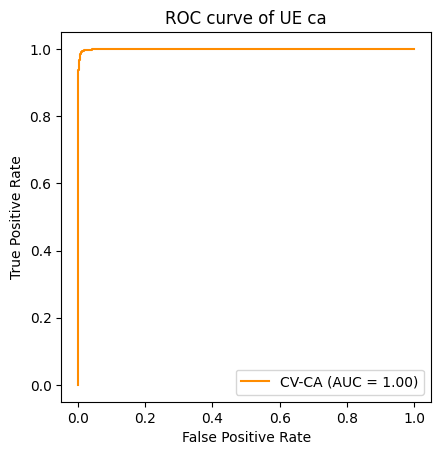

In [19]:

RocCurveDisplay.from_predictions(
    # labels, predictions,
    np.array(opt_list).ravel(), np.array(ca_list).ravel(),
    pos_label=1,
    name='CV-CA',
    color="darkorange",
    plot_chance_level=False,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve of UE ca")
plt.legend()
plt.show()

In [20]:
savemat(
    "./cvca_ca_roc.mat", {
        'label': np.array(opt_list).ravel(),
        'pred': np.array(ca_list).ravel(),
    }
)

: 

In [ ]:

RocCurveDisplay.from_predictions(
    # labels, predictions,
    1+np.array(cat_list).ravel(), np.array(logit_list).ravel(),
    pos_label=1,
    name='CV-CA',
    color="darkorange",
    plot_chance_level=False,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve of UE detection")
plt.legend()
plt.show()

savemat(
    "./cvca_det_roc.mat", {
        'label': np.array(cat_list).ravel(),
        'pred': np.array(logit_list).ravel(),
    }
)

In [ ]:
torch.save(net.state_dict(), './cvca.pth')

In [ ]:

fpr, tpr, thresholds = roc_curve(np.array(opt_list).ravel(), np.array(ca_list).ravel(), pos_label=1)
m, idx = -1, None
for i, (f, t, l) in enumerate(zip(fpr, tpr, thresholds)):
    if f == 0: 
        print(t, l)
    if (1-f)*t > m:
        m = f*t
        idx = i
m, thresholds[idx]
